In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15, 8]

from Data import Data
from Residue import Residue
from Efficiency import Efficiency

from lmfit import Parameters, Minimizer
from lmfit.printfuncs import report_fit

os.environ['ENSDF_PATH'] = os.getcwd() + "/ensdf/"
from nudel.core import Nuclide

from uncertainties import ufloat

In [2]:

nucN  = Nuclide( 15, 8 )
nucAl = Nuclide( 28,  14 )
nucCo = Nuclide( 60,  28 )
nucCs = Nuclide( 137, 56 )
nucBa = Nuclide( 133, 55 )

In [3]:
# Felsenkeller Data
dataCo = Data( "data/60co_fels.dat"  )
dataCs = Data( "data/137cs_fels.dat" )
dataAl = Data( "data/27al_fels.dat"  )

resCs = Residue( dataCs, nucCs, [ [661.659,  ufloat(0.8505, 0.0029)] ] )
resCo = Residue( dataCo, nucCo, [ [2505.753, ufloat(1,           0)] ] )
resAl = Residue( dataAl, nucAl, [ [12541.5,  ufloat(1,           0)] ] )
    
residues = [ resCo, resCs, resAl ]

662  keV - 1 different paths found for populated state 661.659 with 0.8505+/-0.0029 branching!

661.657 (100.0)	Total Probability: 0.8505+/-0.0029

---------------------------------------------------------------------------------

1173  keV - 1 different paths found for populated state 2505.753 with 1.0+/-0 branching!

1173.228 (100.0) -- 1332.501 (100.0)	Total Probability: 0.9999239857786012+/-0

---------------------------------------------------------------------------------

1332  keV - 2 different paths found for populated state 2505.753 with 1.0+/-0 branching!

347.14 (0.0076) -- 826.06 (100.0) -- 1332.501 (100.0)	Total Probability: (6.462093785644021+/-0)e-05
1173.228 (100.0) -- 1332.501 (100.0)	Total Probability: 0.9999239857786012+/-0

---------------------------------------------------------------------------------

276  keV - 2 different paths found for populated state 437.011 with 0.716+/-0 branching!

276.3989 (11.8) -- 79.6142 (100.0) -- 80.9979 (100.0)	Total Probability:

In [4]:
# Function to calculate the efficiency in a given range
def get_eff( params, xmin=0, xmax=12000 ):
    eff_func = Efficiency( )
    x, eff, eff_tot = [ ], [ ], [ ]
    for i in range( xmin, xmax ):
        x.append( i )
        eff.append( eff_func.effPeak( params ) )
        eff_tot.append( eff_func.effTot( params ) )
    return x, eff, eff_tot

# Function to get all the data that can be plotted
def get_data( params ):
    x, disc, data, model, model_no_sum = [ ], [ ], [ ], [ ], [ ]
    for res in residues:
        x            += res.get_energies( )
        disc         += res.get_disc( params )
        data         += res.get_data( )
        model        += res.get_yields( params )
        model_no_sum += res.get_yields_no_sum( params )
    for idx in range( len( disc ) ):
        data[idx]         = [data[idx].nominal_value,data[idx].std_dev]
        disc[idx]         = [disc[idx].nominal_value,disc[idx].std_dev]
        model[idx]        = [model[idx].nominal_value,model[idx].std_dev]
        model_no_sum[idx] = [model_no_sum[idx].nominal_value,model_no_sum[idx].std_dev]
    x            = np.asarray( x )
    disc         = np.asarray( disc )
    data         = np.asarray( data )
    model        = np.asarray( model )
    model_no_sum = np.asarray( model_no_sum )
    return x, disc, data, model, model_no_sum

# Function that calculates the chi2
def chi2( params ):
        chi2 = []
        for res in residues:
            chi2.append( sum( res.get_chi2( params ) ) )
        return chi2

In [5]:
params = Parameters()

#               (NAME    VALUE    VARY   MIN  MAX  EXPR  BRUTE)
params.add_many(('a',       -6,  True,  None,    2, None, None),
                ('b',      0.5,  True,    -2,    2, None, None),
                ('c',     -0.1,  True,    -2,    0, None, None),
                ('k1',    -2.0,  True,    -5,    2, None, None),
                ('k2',    -0.3,  True,    -5,    2, None, None),
                ('k3',    -0.2,  True,    -5,    0, None, None),
                ('R_Al',  7500,  True,  None, None, None, None)
                #('R_N',  7500,  True,  None, None, None, None)
                )

minner = Minimizer( chi2, params )

In [6]:
x, disc, data, model, model_no_sum = get_data( params )

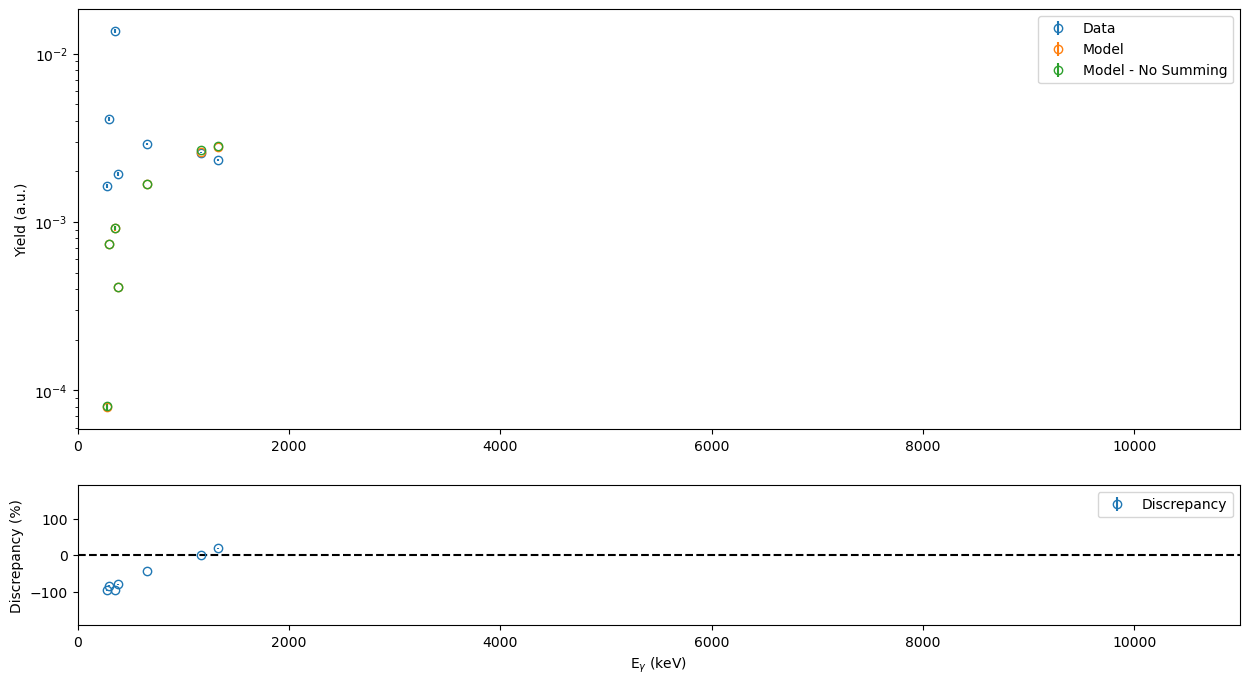

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]})

ax1.errorbar( x, data[:,0], yerr=data[:,1], label="Data", marker='o', linestyle = 'None', markerfacecolor='None' )
ax1.errorbar( x, model[:,0], yerr=model[:,1], label="Model", marker='o', linestyle = 'None', markerfacecolor='None' )
ax1.errorbar( x, model_no_sum[:,0], yerr=model_no_sum[:,1], label="Model - No Summing", marker='o', linestyle = 'None', markerfacecolor='None' )

ax1.set_yscale( "log" )
ax1.set_xlim( 0, 11000 )
ax1.set_ylabel( "Yield (a.u.)")

ax1.legend( )

ax2.errorbar( x, 100*disc[:,0], yerr=100*disc[:,1], label="Discrepancy", marker='o', linestyle = 'None', markerfacecolor='None' )
ax2.hlines( y=0, xmin=0, xmax=11000, linestyle="--", color="k" )

ax2.legend( )
ax2.set_ylim( [-2*max(abs(100*disc[:,0])),2*max(abs(100*disc[:,0]))] )
ax2.set_xlim( 0, 11000 )
ax2.set_ylabel( "Discrepancy (%)")
ax2.set_xlabel( "E$_{\gamma}$ (keV)")

plt.show( )

In [8]:
result = minner.minimize( method='nelder' )
report_fit( result )

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1454
    # data points      = 3
    # variables        = 7
    chi-square         = 667650.630
    reduced chi-square = 667650.630
    Akaike info crit   = 50.9387241
    Bayesian info crit = 44.6290101
##  Warning: uncertainties could not be estimated:
    c:    at boundary
    k1:   at boundary
    k3:   at boundary
[[Variables]]
    a:   -5.88614121 (init = -6)
    b:   -0.83991151 (init = 0.5)
    c:    0.00000000 (init = -0.1)
    k1:   2.00000000 (init = -2)
    k2:  -1.86989667 (init = -0.3)
    k3:  -1.7764e-14 (init = -0.2)
    R_N:  42381.6896 (init = 7500)


In [9]:
x, disc, data, model, model_no_sum = get_data( result.params )

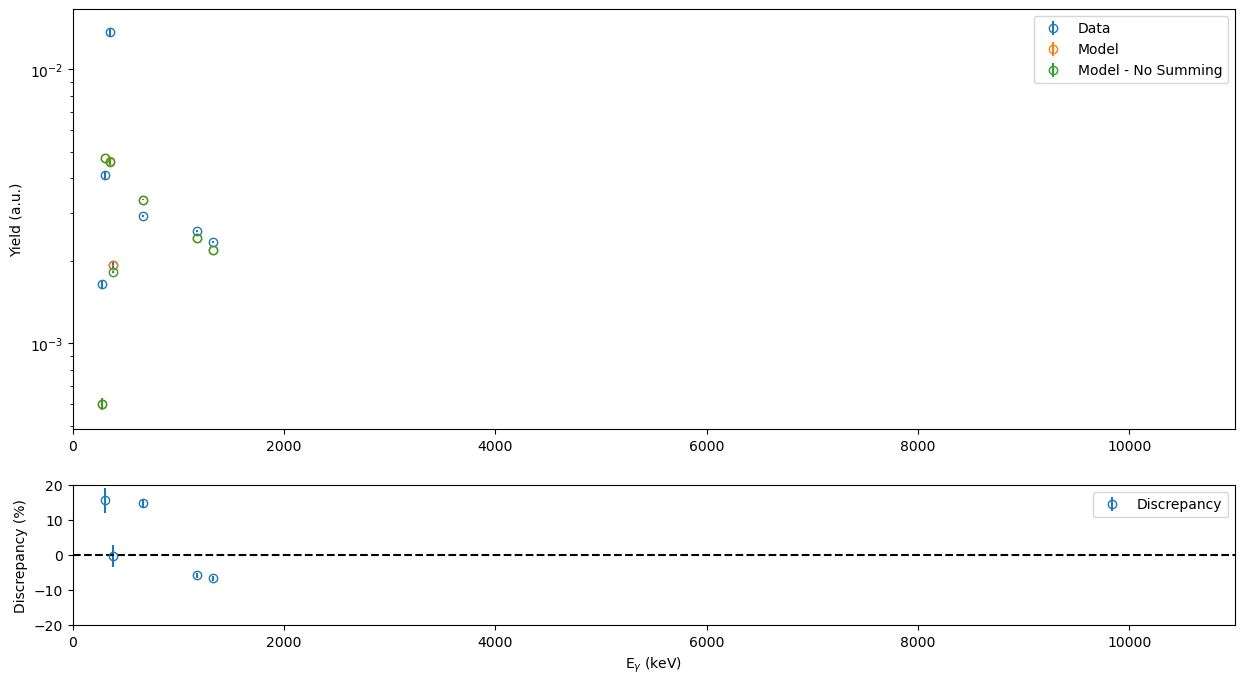

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]})

ax1.errorbar( x, data[:,0], yerr=data[:,1], label="Data", marker='o', linestyle = 'None', markerfacecolor='None' )
ax1.errorbar( x, model[:,0], yerr=model[:,1], label="Model", marker='o', linestyle = 'None', markerfacecolor='None' )
ax1.errorbar( x, model_no_sum[:,0], yerr=model_no_sum[:,1], label="Model - No Summing", marker='o', linestyle = 'None', markerfacecolor='None' )

ax1.set_yscale( "log" )
ax1.set_xlim( 0, 11000 )
ax1.set_ylabel( "Yield (a.u.)")

ax1.legend( )

ax2.errorbar( x, 100*disc[:,0], yerr=100*disc[:,1], label="Discrepancy", marker='o', linestyle = 'None', markerfacecolor='None' )
ax2.hlines( y=0, xmin=0, xmax=11000, linestyle="--", color="k" )

ax2.legend( )
ax2.set_ylim( [-20,20] )
ax2.set_xlim( 0, 11000 )
ax2.set_ylabel( "Discrepancy (%)")
ax2.set_xlabel( "E$_{\gamma}$ (keV)")

plt.show( )